In [1]:
import pandas as pd
import numpy as np

In [2]:
fill_df = pd.read_csv("fullMnist.csv", index_col=0)

In [53]:
from dataclasses import dataclass # Requires Python version 3.7

@dataclass
class modelClass:
    clazz: str
    firstIndex: int
    lastIndex: int

class TimsEfficientLdaClassifier:
    def __init__(self, df: pd.DataFrame):
        self.classes = []
        self.sampleSize: int
        self.classMeans = []
        data = df.sort_values(by=['label'])
        data = data.reset_index(drop=True)
        for clazz in data.label.unique():
            classSubsetIndexes = data.loc[data['label'] == clazz].index
            self.classes.append(modelClass(str(clazz), classSubsetIndexes[0], classSubsetIndexes[-1]))
        self.trainData = data.drop(columns='label').to_numpy()
        self.trainLabels = data.label.to_numpy()
        self.sampleSize = self.trainData.shape[1]  
        self.numSamples = self.trainData.shape[0]
        
    def buildClassMeans(self):
        for clazz in self.classes:
            self.classMeans.append(np.mean(self.trainData[clazz.firstIndex:clazz.lastIndex + 1], axis=0))

    def withinClassCovariance(self):
        withinClassCov = np.zeros(shape=(self.sampleSize, self.sampleSize))
        for clazz in  self.classes:
            withinClassCov += self._withinClassCovarianceForClass(clazz)
        self.withinClassCovariance = withinClassCov
    
    def _withinClassCovarianceForClass(self, clazz):
        classCov = np.zeros(shape=(self.sampleSize, self.sampleSize))
        classIndex = self.classes.index(clazz)
        for i in range(clazz.firstIndex, clazz.lastIndex + 1):
            currentRow = np.subtract(self.trainData[i], self.classMeans[classIndex])
            currentRow = np.outer(np.transpose(currentRow), currentRow)
            classCov += currentRow
        return classCov

    def betweenClassCovariance(self):
        sbCovariance = np.zeros(shape=(self.sampleSize, self.sampleSize))
        globalMean = np.sum(self.trainData, axis=0) / self.numSamples
        for clazz in self.classes:
            currentClass = np.subtract(self.classMeans[self.classes.index(clazz)], globalMean)
            currentClass = np.outer(np.transpose(currentClass), currentClass)
            # Scale by the number of samples of this class
            currentClass = currentClass * (clazz.lastIndex + 1 - clazz.firstIndex)
            sbCovariance += currentClass
        self.betweenClassCovariance = sbCovariance

    def getSortedEigens(self):
        weightMatrix = np.matmul(np.linalg.pinv(self.withinClassCovariance), self.betweenClassCovariance)
        eigenValues, self.eigenVectors = np.linalg.eig(weightMatrix)
        # Transpose the eigenVectors because of the way it returns and the way I am indexing it
        self.eigenVectors = np.transpose(self.eigenVectors)        
        # Add index for each eigenvalue so that it can be correllated to its eigenvector after a sort
        eigenValues = np.c_[eigenValues, range(0, eigenValues.shape[0])]
        # Sort the eigenValues largest first
        self.sortedEigenValues = np.flip(eigenValues[eigenValues[:,0].argsort()], axis=0)
    
    def createMapToLowerDimensionality(self, lowerDimension: int):
        self.lowerDimension = lowerDimension
        self.w = np.zeros(shape=(self.lowerDimension, self.sampleSize), dtype=np.complex128)
        for i in range(0, self.lowerDimension):
            self.w[i] = self.eigenVectors[int(self.sortedEigenValues[i][1].real)]
        self.w = np.transpose(self.w)

    def projectDataToLowerDimension(self):
        self.projectedData = np.matmul(self.trainData, self.w)

     #TODO: re-write
    def gaussian(self):
        # get projected means
        self.projectedMeans = np.zeros(shape=(len(self.classes), self.lowerDimension))
        self.projectedCov = np.zeros(shape=(len(self.classes), self.lowerDimension, self.lowerDimension))
        self.projectedPriors = np.zeros(shape=(len(self.classes), self.lowerDimension))
        for clazz in self.classes:
            indexForClass = self.classes.index(clazz)
            self.projectedMeans[indexForClass], self.projectedCov[indexForClass], self.projectedPriors[indexForClass] = self.guassianForClass(clazz)

    # rewrite?
    def guassianForClass(self, clazz):
        classSubset = self.trainData[clazz.firstIndex:clazz.lastIndex + 1]
        numSamplesForClass = clazz.lastIndex + 1 - clazz.firstIndex
        projectedClassSubset = np.matmul(classSubset, self.w).real
        classSubsetMeans = np.mean(projectedClassSubset, axis=0)
        classSubsetCov = np.cov(projectedClassSubset, rowvar=False)
        classSubsetPriors = numSamplesForClass / self.numSamples
        return classSubsetMeans, classSubsetCov, classSubsetPriors

    # rewrite?
    def score(self, testData, labels):
        projectedData = np.matmul(testData, self.w)
        gaussian_likelihoods = np.zeros(shape=(projectedData.shape[0], len(self.classes)))
        for i, row in enumerate(projectedData):
            res = np.zeros(shape=(len(self.classes)), dtype=np.complex128)
            for clazz in self.classes:
                indexForClass = self.classes.index(clazz)
                res[indexForClass] = (self.projectedPriors[indexForClass] * self.gaussian_distribution( row,
                                        self.projectedMeans[indexForClass], self.projectedCov[indexForClass]))[0]
            gaussian_likelihoods[i] = res
        predictions = np.argmax(gaussian_likelihoods, axis=1)
        return np.sum(predictions == labels) / len(labels), predictions, projectedData

    # rewrite?
    def gaussian_distribution(self, data, mean, cov):
        scalar = (1. / ((2 * np.pi) ** (data.shape[0] / 2.))) * (1/ np.sqrt(np.linalg.det(cov)))
        x_sub_u = np.subtract(data, mean)
        return scalar * np.exp(-np.dot(np.dot(x_sub_u, np.linalg.pinv(cov)), x_sub_u.T) / 2.)

        

    
        

In [41]:
a = np.array([[1,1,1],[1,1,1],[1,1,1],[2,2,2]])
print(np.mean(a[0:3 + 1], axis=0))
print(a[3])

[1.25 1.25 1.25]
[2 2 2]


In [67]:
newClassifier = TimsEfficientLdaClassifier(fill_df.head(60000))
testData = fill_df.tail(10000).drop(columns='label').to_numpy()
testLabels = fill_df.tail(10000).label.to_numpy()

In [68]:
newClassifier.buildClassMeans()

In [69]:
newClassifier.withinClassCovariance()

In [70]:
newClassifier.betweenClassCovariance()

In [71]:
newClassifier.getSortedEigens()

In [72]:
newClassifier.createMapToLowerDimensionality(2)

In [73]:
newClassifier.projectDataToLowerDimension()

In [74]:
newClassifier.gaussian()

In [75]:
accuracy, predictions, projectedData = newClassifier.score(testData, testLabels)

C:\Users\timmy\AppData\Local\Temp\ipykernel_15344\630297989.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  gaussian_likelihoods[i] = res


[3.51721059e-12+0.j 1.39806498e-20+0.j 2.58009506e-07+0.j
 1.58849595e-07+0.j 3.64755048e-04+0.j 6.12963596e-08+0.j
 1.53318041e-13+0.j 2.47878581e-03+0.j 1.13638863e-09+0.j
 2.34743952e-03+0.j]
[8.04526938e-08+0.j 1.50132988e-29+0.j 1.04826942e-05+0.j
 3.73318107e-07+0.j 5.15111523e-15+0.j 9.15779505e-07+0.j
 8.24453631e-05+0.j 1.69281592e-14+0.j 1.31740830e-08+0.j
 1.75120734e-14+0.j]
[3.17274721e-12+0.j 6.62305412e-03+0.j 1.09740254e-04+0.j
 3.78335877e-05+0.j 9.87635276e-10+0.j 3.03479531e-08+0.j
 9.47479678e-07+0.j 4.48410076e-07+0.j 1.40626689e-04+0.j
 5.81837715e-11+0.j]
[3.03756738e-03+0.j 9.94070634e-31+0.j 1.98302154e-07+0.j
 9.04911676e-10+0.j 5.71857654e-13+0.j 5.62244892e-08+0.j
 1.16046851e-04+0.j 5.89446635e-15+0.j 3.13917793e-08+0.j
 9.13465351e-15+0.j]
[1.06637451e-06+0.j 6.52510627e-10+0.j 8.34620770e-05+0.j
 2.21263932e-04+0.j 3.27768416e-03+0.j 1.02236147e-04+0.j
 3.15178712e-07+0.j 8.73399880e-04+0.j 5.72569170e-05+0.j
 1.99755295e-03+0.j]
[2.67644071e-15+0.j 5.466

In [76]:
print(accuracy)


0.565


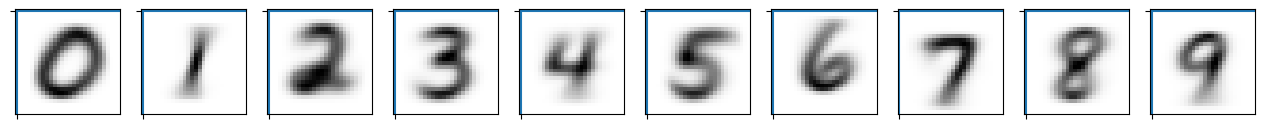

In [77]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# now let's show some randomly chosen images from the traininng set.
count = 0
sample_size = 10
plt.figure(figsize=(16, 6))
for i in range(0, sample_size):
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.imshow(newClassifier.classMeans[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()

C:\Users\timmy\OneDrive\GradSchool\MachineLearning\project\lib\site-packages\matplotlib\collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


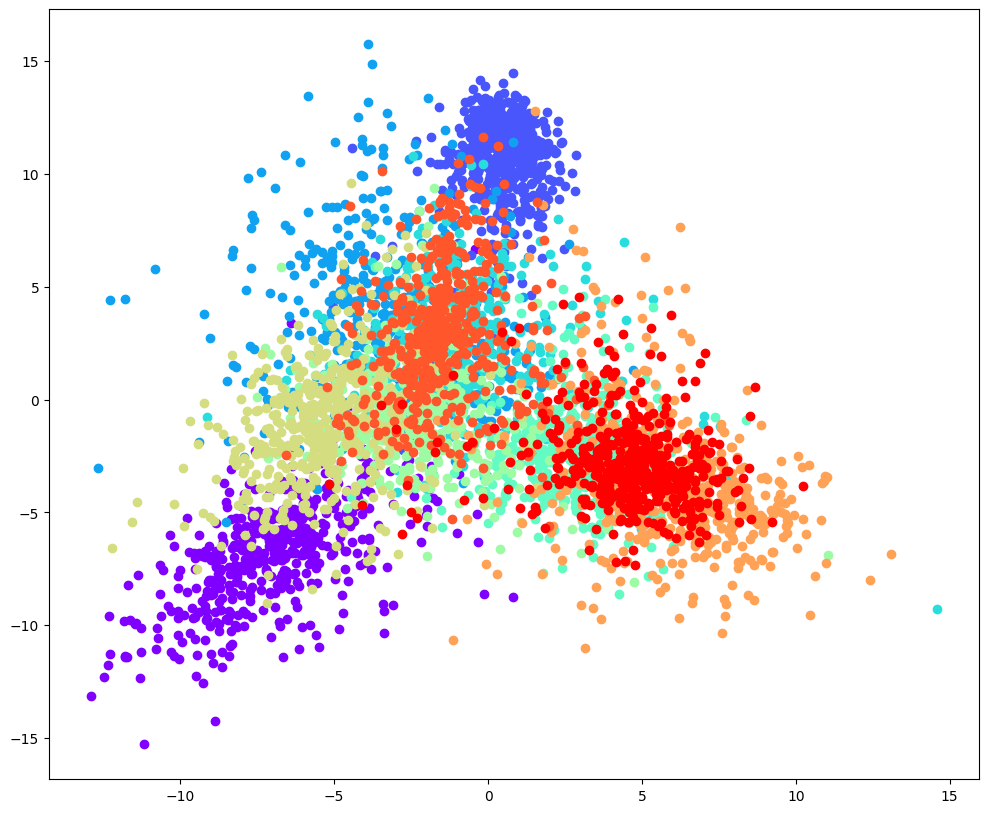

In [78]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Graph the projected data 

colors = cm.rainbow(np.linspace(0, 1, len(newClassifier.classes)))

plt.figure(figsize=(12,10))
stride = 12
for i, point in enumerate(newClassifier.projectedData[::stride]):
    plt.scatter(point[0], point[1], color=colors[newClassifier.trainLabels[i*stride]])

plt.show()

C:\Users\timmy\OneDrive\GradSchool\MachineLearning\project\lib\site-packages\matplotlib\collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


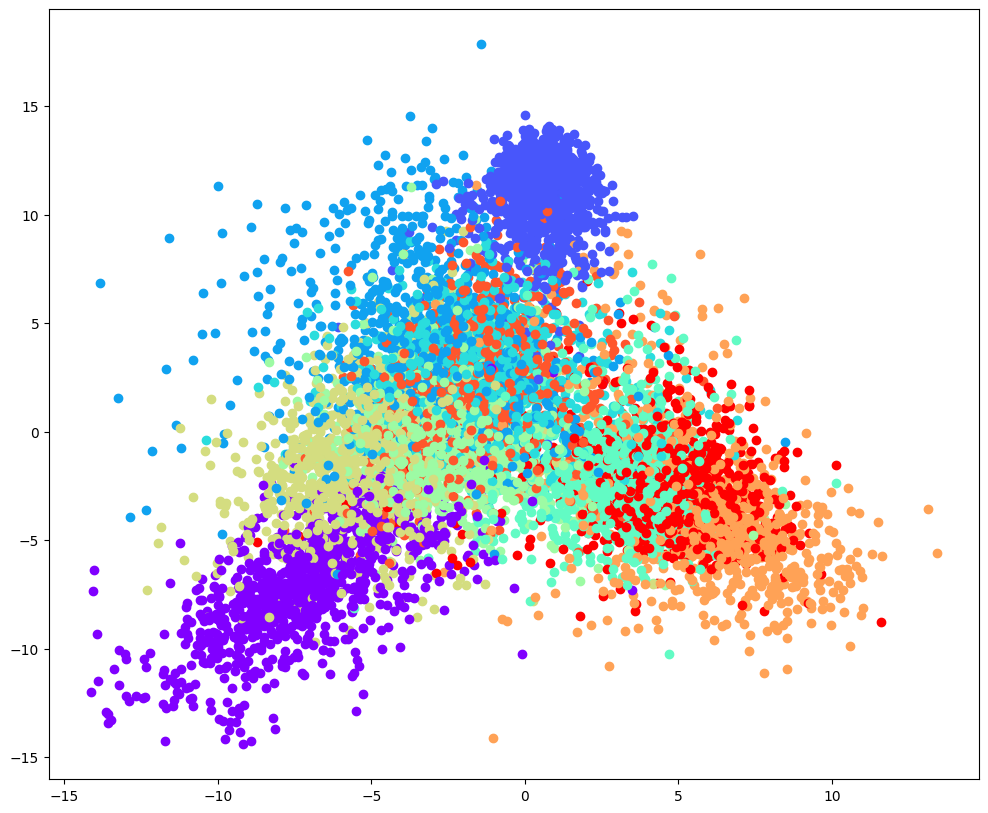

In [82]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Plot the projected test data and color by the known label

colors = cm.rainbow(np.linspace(0, 1, len(newClassifier.classes)))

plt.figure(figsize=(12,10))
stride = 12
for point, label in zip(projectedData, testLabels):
    plt.scatter(point[0], point[1], color=colors[label])

plt.show()

0.565


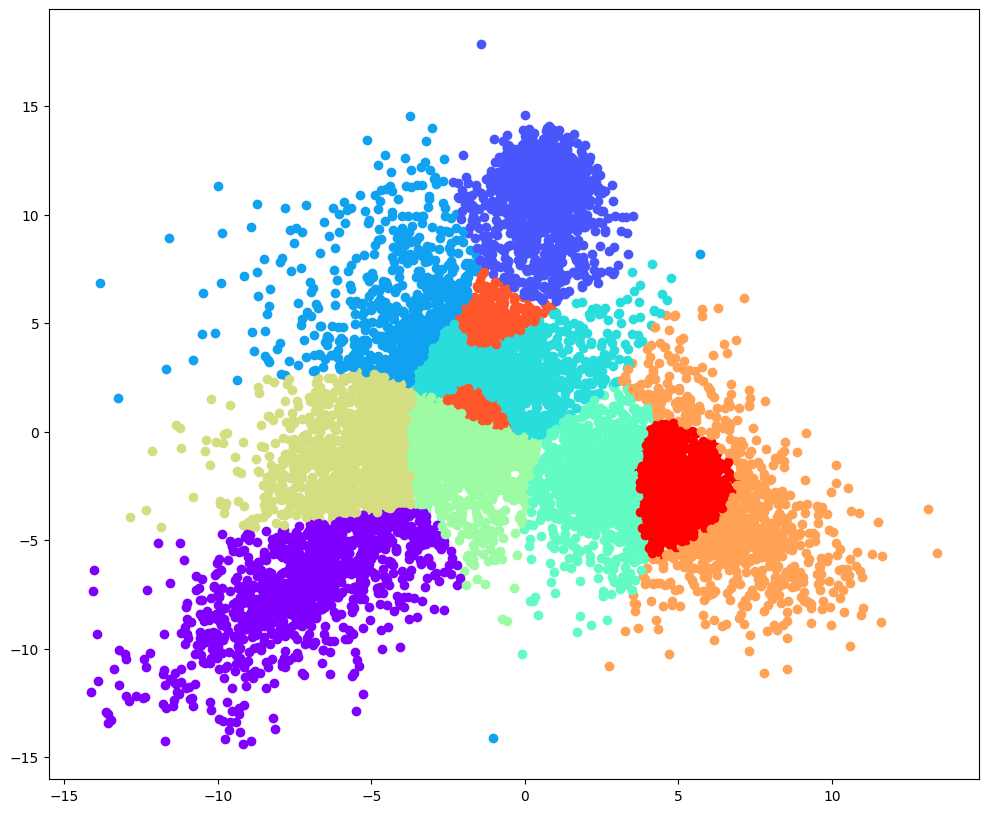

In [79]:
colors = cm.rainbow(np.linspace(0, 1, len(newClassifier.classes)))

# Plot the projected test data and color by the prediction

plt.figure(figsize=(12,10))
for point,pred in zip(projectedData,predictions):
  plt.scatter(point[0],point[1],color=colors[pred])
plt.show()